# Importing packages

In [1]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)

/blue/ferrallm/mcremer/cardiac-amyloidosis/026_SVM_mistic2


In [2]:
import sys
# sys.path.append('/Users/c.kieslich/Box Sync/Research/featureSelection/')

from mistic.svmSet import svmSet
from mistic.cvSet import cvSet 
from mistic.utility import combined_rank, kernelWrapper, score_svc, perDiff, paramSet

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [3]:
import pickle

In [4]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

# directory management

In [5]:
# this is written to work out of the blue folder on hpg 

#for file outputs
fileName_header = "Mistic2_descFits" #what data did you put in
fileName_common = "_linear" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_250123_v1" #date and versioning

saving_dirrectory = "012 Processed Data"
makingFolder = makeFolderPathForData(parent_dir= saving_dirrectory, folderName_header= "Mistic2_descFits_linear_", folderName_common= "250123_", 
                                     folderName_suffix= "v1")
dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = "012 Processed Data"
figFolder = makingFolder 


In [6]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

In [7]:
#parameters of SVM 
red_factor = 0.05

#cross validation and splitting 
test_size_numb = 1/5
numb_sets = 5

C_range = [2**x for x in range(-2,5)]
# gamma_range = [2**x for x in range(-9,1)]


kernel_type = "linear"

rank_weights = [0,0.25,0.50,0.75,1]

# importing our data

In [8]:
dataFileName = "AL-KnownPts_CompLabswoEcho_exG01J01_MDfits_1Sheet_20241022_v1.xlsx"

In [9]:
# Import dataset
dataTable = pd.read_excel(dataFileName, header = 0) #the dataset we are using

# Setting up classifier

## Scaling data and defining test set

In [10]:
#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'Amyloid Status_yes', 'Amyloid Status_no', "Amyloid Status_unk"]


#columns to use for the y data 
y_column_Classification = 'Amyloid Status_yes'

In [11]:
X = dataTable.copy()
X.drop(columns=x_columns_toDrop,inplace=True)
scaler = StandardScaler()
scaler.fit(X)

X_all = scaler.transform(X)
y_all = dataTable[y_column_Classification]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    stratify = y_all, 
                                                    random_state= 0, 
                                                    test_size= test_size_numb)

## define cross validation

In [12]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = numb_sets)

## initiallize SVC and parameter grids

In [13]:
svc = SVC(kernel = 'precomputed', class_weight="balanced", probability=False, tol = 1e-12)


parameter_grid = []
for cost in C_range:
    parameter_grid.append(paramSet(model={"C": cost},kernel={}))

# feature selection

In [14]:

svm_set_ranks = []
for i in range(len(rank_weights)):
    print(f"Rank weight: {rank_weights[i]:.2f}")
    svm_set_ranks.append(svmSet(svc, cv_set,
                                score_method = score_svc().score,
                                kernel = kernelWrapper(type = kernel_type),
                                separate_feature_sets = False,
                                separate_parameters = False,
                                sparse_kernel_matrix = False))

    svm_set_ranks[i].greedy_backward_selection(parameter_grid = parameter_grid,
                                           reduction_factor = red_factor,
                                           feature_ranker = combined_rank(weight=rank_weights[i]).compute,
                                           set_for_rank = "sample")

Rank weight: 0.00
Number of Features: 641, Score: 0.704
Number of Features: 608, Score: 0.694
Number of Features: 577, Score: 0.704
Number of Features: 548, Score: 0.704
Number of Features: 520, Score: 0.726
Number of Features: 493, Score: 0.745
Number of Features: 468, Score: 0.745
Number of Features: 444, Score: 0.695
Number of Features: 421, Score: 0.734
Number of Features: 399, Score: 0.756
Number of Features: 379, Score: 0.745
Number of Features: 360, Score: 0.715
Number of Features: 341, Score: 0.705
Number of Features: 323, Score: 0.620
Number of Features: 306, Score: 0.662
Number of Features: 290, Score: 0.570
Number of Features: 275, Score: 0.622
Number of Features: 261, Score: 0.633
Number of Features: 247, Score: 0.633
Number of Features: 234, Score: 0.642
Number of Features: 222, Score: 0.558
Number of Features: 210, Score: 0.673
Number of Features: 199, Score: 0.658
Number of Features: 189, Score: 0.647
Number of Features: 179, Score: 0.502
Number of Features: 170, Score: 

In [15]:
# # add pickling stage here so that you can use this data for easy replotting

# #if not already pickled use this block
# pickle_file_name = 'svmsetsPickle_' + fileName_header + fileName_suffix
# pickle_filePath = os.path.join(saving_dirrectory, pickleFolderOut, pickle_file_name)
# pickle_file = open(pickle_filePath, 'wb')
# pickle.dump(svm_set_ranks, pickle_file)



# Performance plots

## F1 and AUC plots

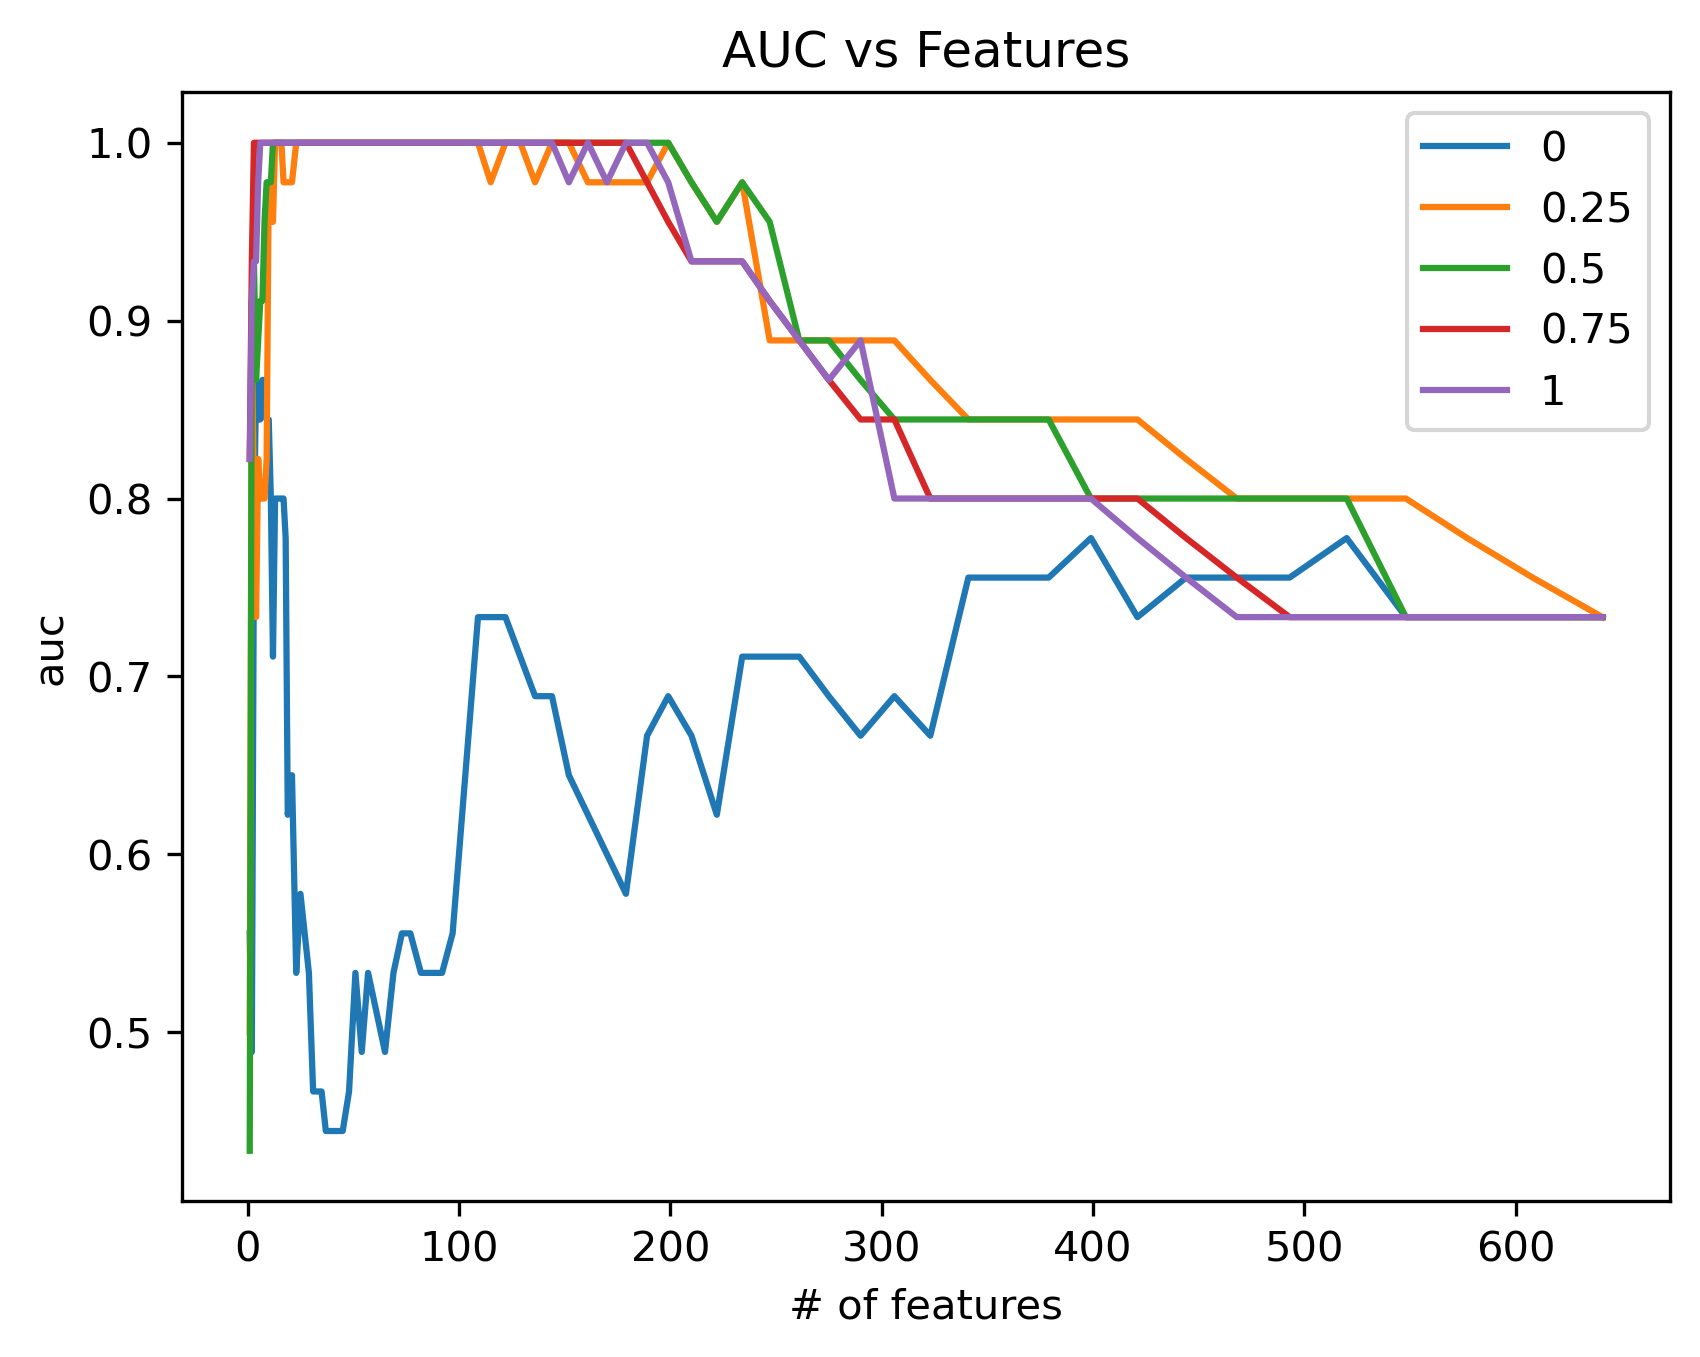

In [16]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="auc")

plt.legend(labels=rank_weights)
ax.set_title("AUC vs Features")

#saving figure
figCommon = fileName_common + "_AUC"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

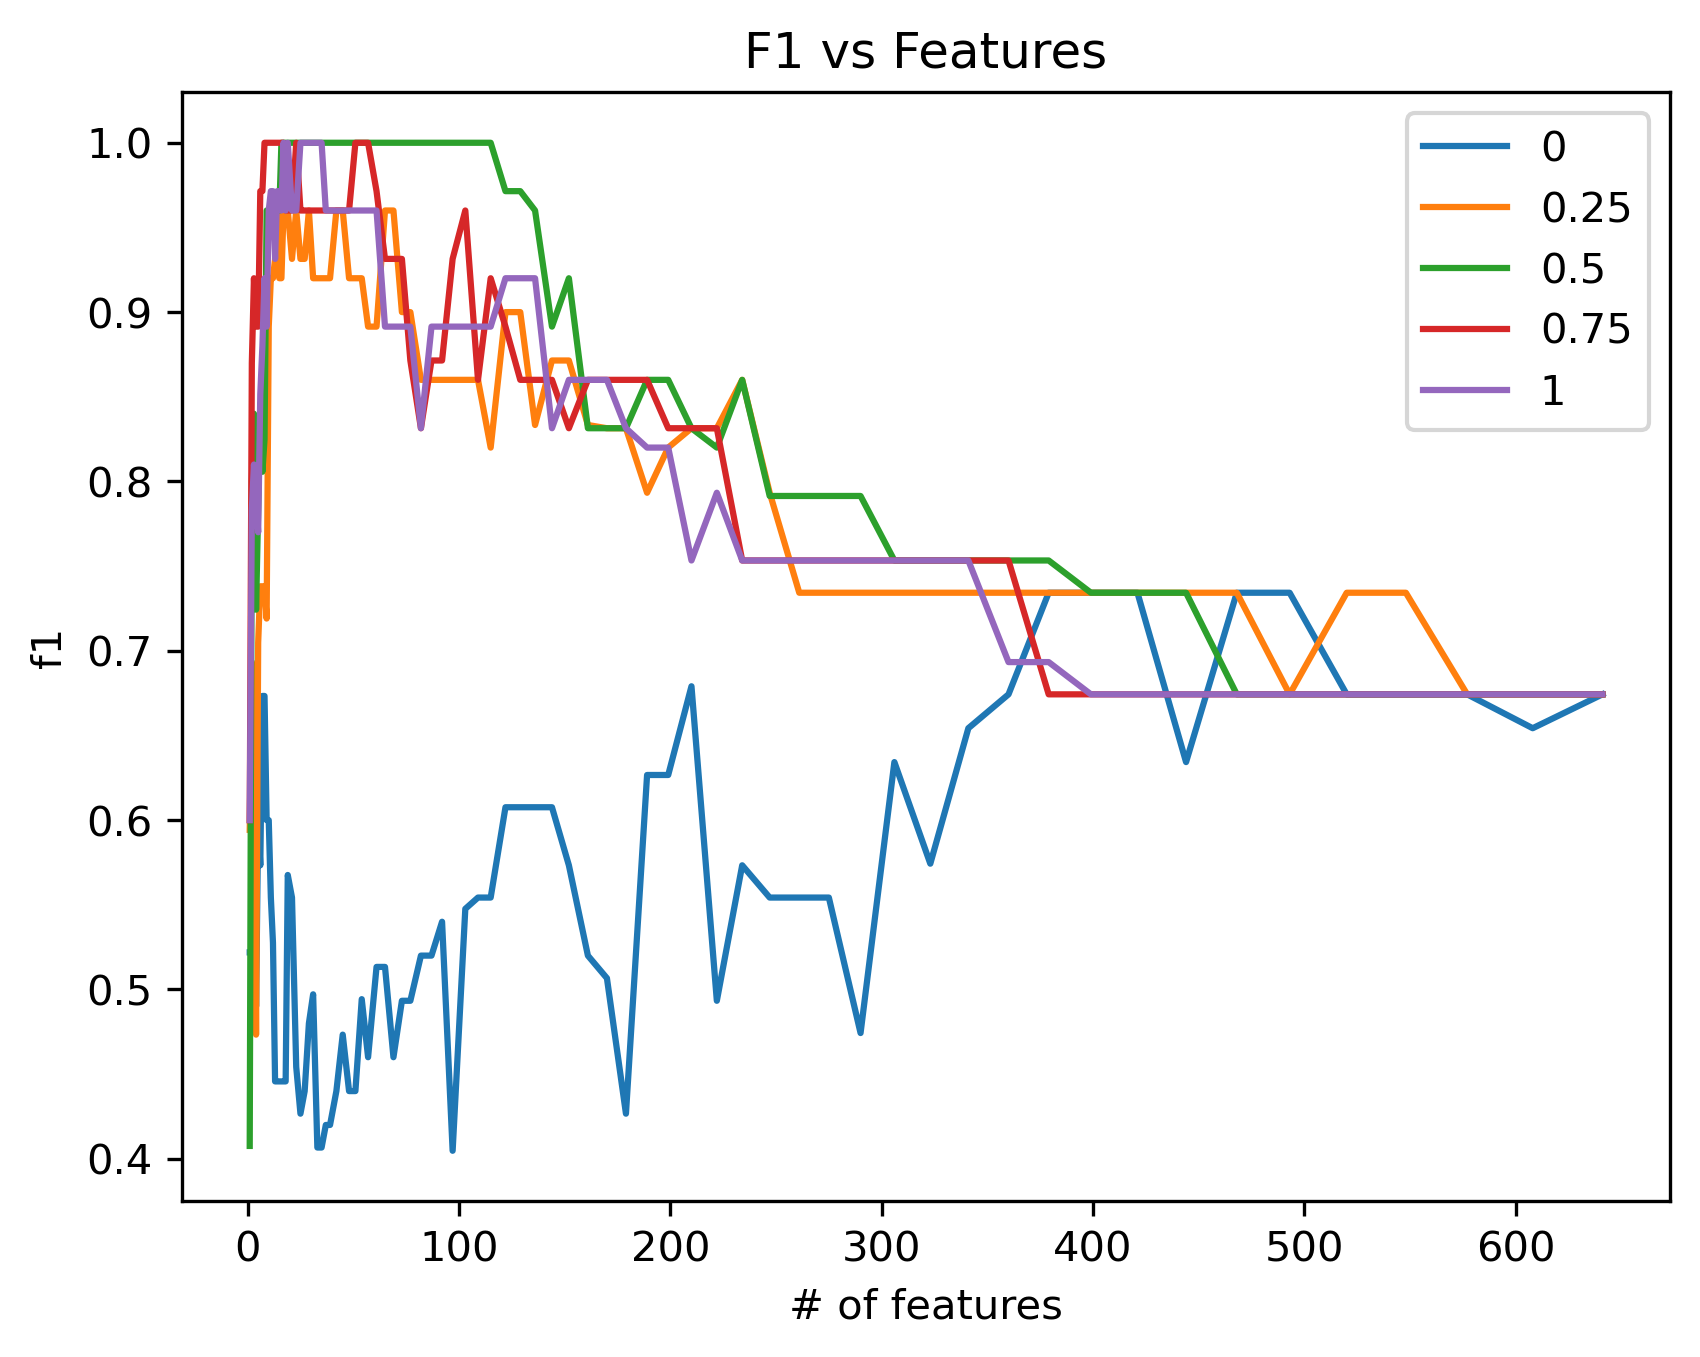

In [17]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="f1")

plt.legend(labels=rank_weights)
ax.set_title("F1 vs Features")

#saving figure
figCommon = fileName_common + "_F1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

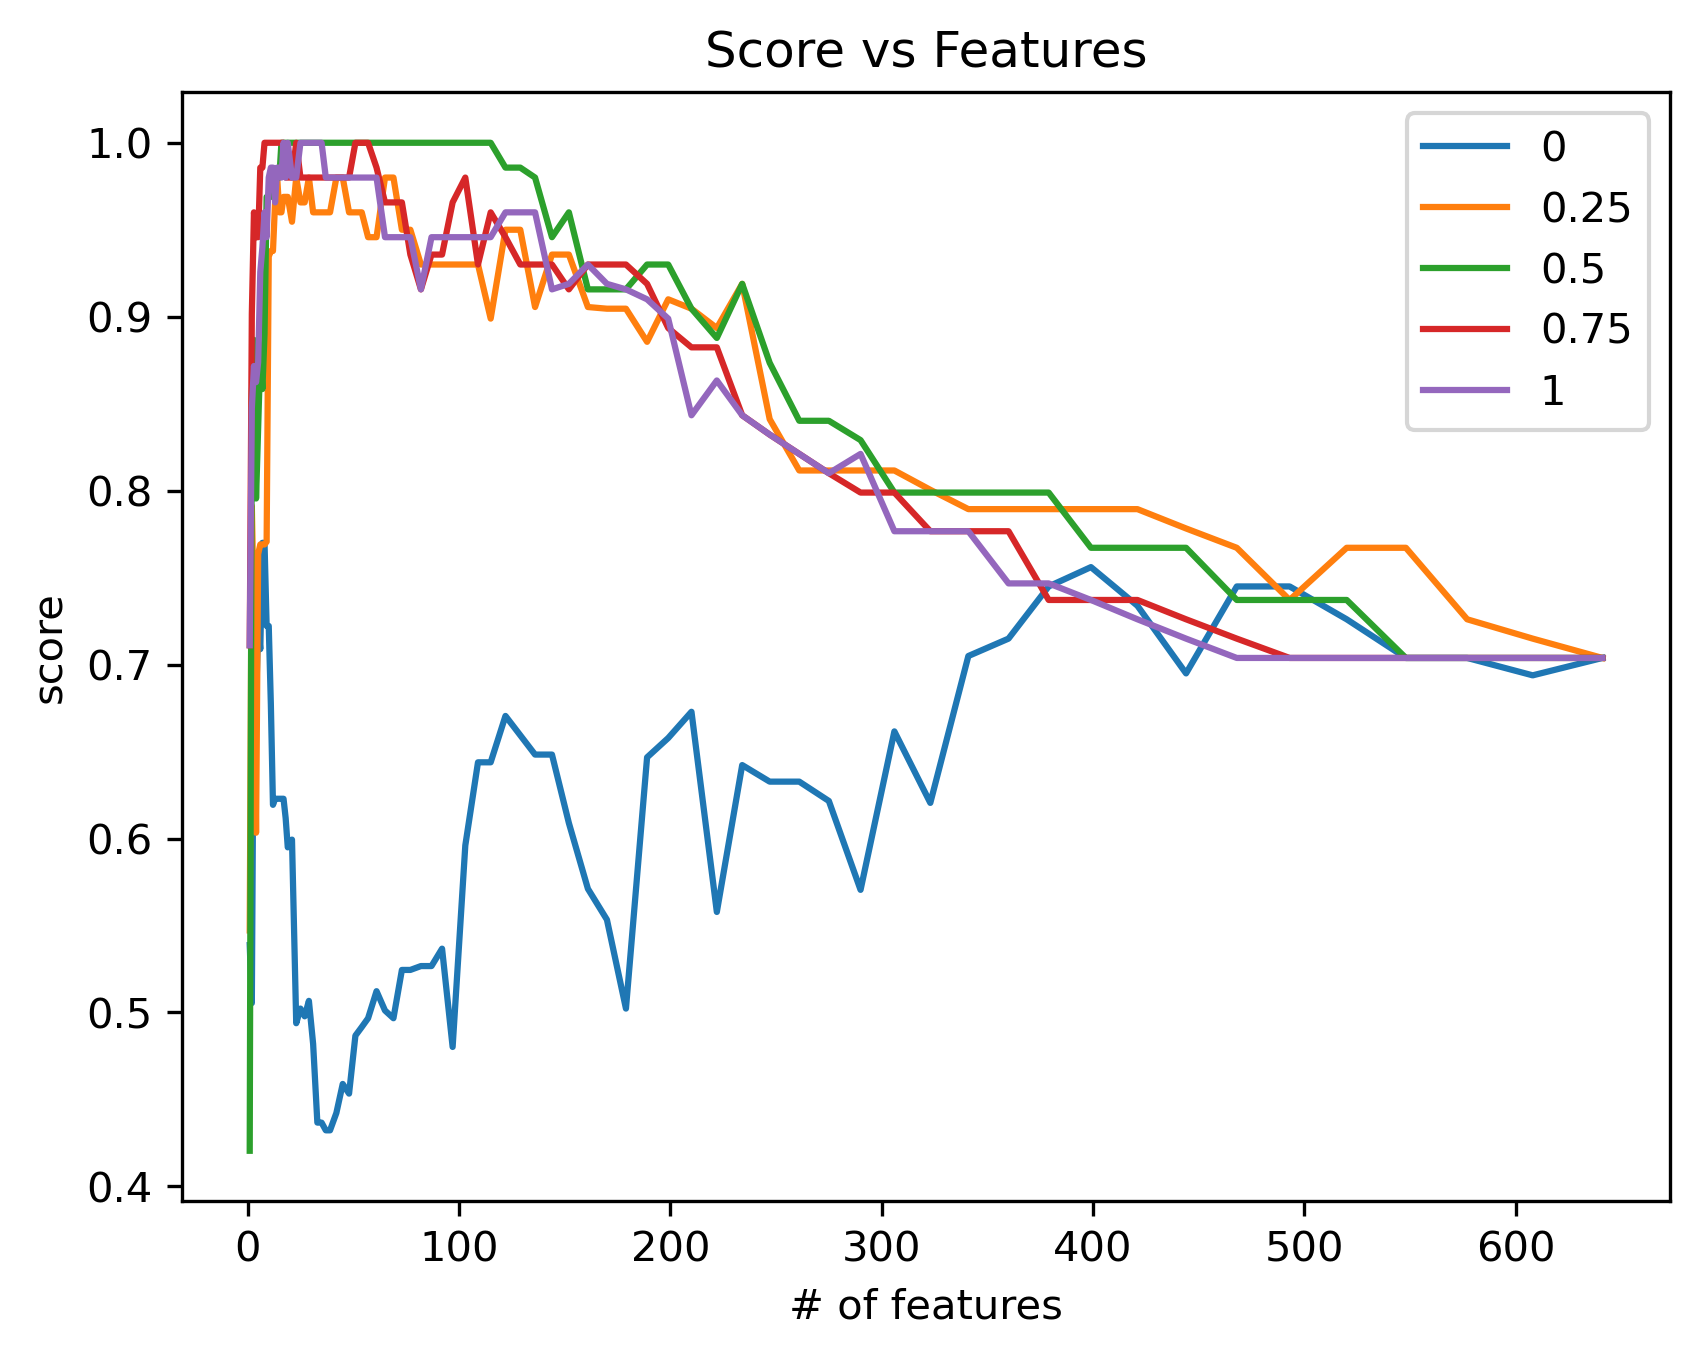

In [18]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="score")

plt.legend(labels=rank_weights)
ax.set_title("Score vs Features")

#saving figure
figCommon = fileName_common + "_Score"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

# picking best model 

In [19]:
enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score())

# selected_run = 4 
selected_run = enrich_score.index(max(enrich_score))

enrich_score

[0.6529228883441051,
 0.8274333259044646,
 0.834933759255132,
 0.8130366738479063,
 0.8088101428819059]

In [20]:
svm_set_ranks[selected_run].performance_

{'f1': 1.0,
 'auc': 1.0,
 'score': 1.0,
 'C': 0.25,
 'num_features': 16,
 'mean_nSV': 12.6}

In [21]:
score_list = []

for i in range(len(rank_weights)):
    score_list.append(svm_set_ranks[i].performance_['score'])

maxScore = max(score_list)
topModelIndex = score_list.index(maxScore)


In [22]:
#saving the feature ranking, performance, and model evaluations to spreadsheets

for i in range(len(rank_weights)):
    #collecting the performance as a dataframe
    df_bestPerformance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index')
    outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".", "") + "_best model perf")


    df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[i].features]))
    #saving the best features
    outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".","") + "_features")




In [23]:
# #collecting the performance as a dataframe
# df_bestPerformance = pd.DataFrame(svm_set_ranks[topModelIndex].performance_)
# outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
#               folderName= dataFrameFolderOut, sheetName= str(rank_weights[topModelIndex]) + "_best model perf")


# df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[topModelIndex].features]))
# #saving the best features
# outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
#               folderName= dataFrameFolderOut, sheetName= str(rank_weights[topModelIndex]) + "_features")



In [24]:
for i in range(len(rank_weights)): 
    # print("test")
    print("weight " , str(rank_weights[i]) , " :" ,svm_set_ranks[i].performance_ , '\n')
    print("features: ", "\n", list(X.columns[svm_set_ranks[i].features]), "\n")


weight  0  : {'f1': 0.6733333333333332, 'auc': 0.8666666666666668, 'score': 0.77, 'C': 0.5, 'num_features': 7, 'mean_nSV': 22.2} 

features:  
 ['Age', 'NT Pro BNP (B-Type Natriuretic Peptide) Desc min', 'NT Pro BNP (B-Type Natriuretic Peptide) Desc 50%', 'Serum Electrophoresis Gamma Result Linear R2', 'NT Pro BNP (B-Type Natriuretic Peptide) Linear intercept', 'MCHC Result Exp intercpet', 'Serum Electrophoresis Gamma Result Exp R2'] 

weight  0.25  : {'f1': 0.96, 'auc': 1.0, 'score': 0.9800000000000001, 'C': 0.5, 'num_features': 14, 'mean_nSV': 14.2} 

features:  
 ['Beta-2-Microglobulin Result Desc min', 'Chloride Result(mmol/L) Desc 50%', 'NT Pro BNP (B-Type Natriuretic Peptide) Desc 50%', 'Troponin-T Desc count', 'BUN Result(mg/dL) Linear R2', 'Creatinine Result(mg/dL) Linear coef', 'Serum Electrophoresis Alpha 1 Result Linear coef', 'NT Pro BNP (B-Type Natriuretic Peptide) Linear intercept', 'Troponin-T Linear R2', 'Creatinine Result(mg/dL) Exp coef', 'Total Serum Protein Result E

In [25]:
for i in range(len(rank_weights)):
    decision_values = svm_set_ranks[i].decision_function(X_test)
    y_pred = svm_set_ranks[i].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn + fp)
    f1 = 2*precision*recall/(precision+recall)
    auc = roc_auc_score(y_test, decision_values)

    print("\n The model is: ")
    print("weight " , str(rank_weights[i]) , " :" ,svm_set_ranks[i].performance_ , '\n')
    print("True Negative: ", tn)
    print("false positive: ", fp)
    print("false negative: ", fn)
    print("true positive: ", tp)
    print("true positive rate or recall/sensitivity: ", recall)
    print("positive predictive value or precision: ", precision)
    print("specificity or true negative rate: ", specificity)
    print("auc: ", auc)
    print("f1 score: ", f1)


 The model is: 
weight  0  : {'f1': 0.6733333333333332, 'auc': 0.8666666666666668, 'score': 0.77, 'C': 0.5, 'num_features': 7, 'mean_nSV': 22.2} 

True Negative:  4
false positive:  1
false negative:  1
true positive:  3
true positive rate or recall/sensitivity:  0.75
positive predictive value or precision:  0.75
specificity or true negative rate:  0.8
auc:  0.9
f1 score:  0.75

 The model is: 
weight  0.25  : {'f1': 0.96, 'auc': 1.0, 'score': 0.9800000000000001, 'C': 0.5, 'num_features': 14, 'mean_nSV': 14.2} 

True Negative:  5
false positive:  0
false negative:  2
true positive:  2
true positive rate or recall/sensitivity:  0.5
positive predictive value or precision:  1.0
specificity or true negative rate:  1.0
auc:  1.0
f1 score:  0.6666666666666666

 The model is: 
weight  0.5  : {'f1': 1.0, 'auc': 1.0, 'score': 1.0, 'C': 0.25, 'num_features': 16, 'mean_nSV': 12.6} 

True Negative:  5
false positive:  0
false negative:  1
true positive:  3
true positive rate or recall/sensitivity

In [26]:
iterator = 1
for i in range(len(rank_weights)):
    if iterator == 1:
        #create the df_performance and collect the performance information
        df_performance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T

        #create feature list dataframe 
        df_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        iterator = iterator + 1 #to increment
    else:
        #collect the data and add it to the existing frames
        df_temp_perf = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T
        df_temp_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        #concatinate with pervious
        df_performance = pd.concat([df_performance, df_temp_perf], axis =0)
        df_features = pd.concat([df_features, df_temp_features], axis = 1)
        iterator = iterator + 1

#saving the features and performance
outputToExcel(df_data=df_performance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_best model perf")

outputToExcel(df_data=df_features, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_features")

iterator = 1
dict_blindprediction = {} #index is the weight
for i in range(len(rank_weights)):
    decision_values = svm_set_ranks[i].decision_function(X_test)
    y_pred = svm_set_ranks[i].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn + fp)
    f1 = 2*precision*recall/(precision+recall)
    auc = roc_auc_score(y_test, decision_values)

    dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 'false neg': fn, 'true pos': tp,
                           'precision or PPV': precision, 'recall or TPR': recall, 'specificity or TNR': specificity}
    if iterator == 1:
        df_blindprediction = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        iterator = iterator +1
    else:
        df_temp_blindpred = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        df_blindprediction = pd.concat([df_blindprediction, df_temp_blindpred], axis = 0)
        iterator = iterator + 1
    # print(df_temp_blindpred)
    # dict_blindprediction[str(rank_weights[i])] = df_temp_blindpred

# df_blindprediction = pd.DataFrame.from_dict(dict_blindprediction, orient= 'index')
outputToExcel(df_data=df_blindprediction, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_blindprediction")


In [27]:
df_blindprediction

f1   auc  true neg  false pos  false neg  true pos  \
0     0.750000  0.90       4.0        1.0        1.0       3.0   
0.25  0.666667  1.00       5.0        0.0        2.0       2.0   
0.5   0.857143  0.95       5.0        0.0        1.0       3.0   
0.75  0.666667  0.60       3.0        2.0        1.0       3.0   
1     0.857143  0.95       5.0        0.0        1.0       3.0   

      precision or PPV  recall or TPR  specificity or TNR  
0                 0.75           0.75                 0.8  
0.25              1.00           0.50                 1.0  
0.5               1.00           0.75                 1.0  
0.75              0.60           0.75                 0.6  
1                 1.00           0.75                 1.0

In [28]:
df_performance

f1       auc  score     C  num_features  mean_nSV
0     0.673333  0.866667   0.77  0.50           7.0      22.2
0.25  0.960000  1.000000   0.98  0.50          14.0      14.2
0.5   1.000000  1.000000   1.00  0.25          16.0      12.6
0.75  1.000000  1.000000   1.00  0.25           8.0      12.8
1     1.000000  1.000000   1.00  0.25          17.0      12.8

In [29]:
df_features

0  \
0                                                 Age   
1    NT Pro BNP (B-Type Natriuretic Peptide) Desc min   
2    NT Pro BNP (B-Type Natriuretic Peptide) Desc 50%   
3        Serum Electrophoresis Gamma Result Linear R2   
4   NT Pro BNP (B-Type Natriuretic Peptide) Linear...   
5                           MCHC Result Exp intercpet   
6           Serum Electrophoresis Gamma Result Exp R2   
7                                                 NaN   
8                                                 NaN   
9                                                 NaN   
10                                                NaN   
11                                                NaN   
12                                                NaN   
13                                                NaN   
14                                                NaN   
15                                                NaN   
16                                                NaN   

                                                 0.25  \
0                Beta-2-Microglobulin Result Desc min   
1                    Chloride Result(mmol/L) Desc 50%   
2    NT Pro BNP (B-Type Natriuretic Peptide) Desc 50%   
3                               Troponin-T Desc count   
4                         BUN Result(mg/dL) Linear R2   
5                Creatinine Result(mg/dL) Linear coef   
6    Serum Electrophoresis Alpha 1 Result Linear coef   
7   NT Pro BNP (B-Type Natriuretic Peptide) Linear...   
8                                Troponin-T Linear R2   
9                   Creatinine Result(mg/dL) Exp coef   
10           Total Serum Protein Result Exp intercpet   
11  NT Pro BNP (B-Type Natriuretic Peptide) Exp re...   
12                                  Troponin-T Exp R2   
13                   ECOG Performance Status Desc max   
14                                                NaN   
15                                                NaN   
16                                                NaN   

                                             0.5  \
0           Beta-2-Microglobulin Result Desc min   
1               Chloride Result(mmol/L) Desc 25%   
2              Creatinine Result(mg/dL) Desc 25%   
3                      total CO2 Result Desc 50%   
4                          Troponin-T Desc count   
5        Beta-2-Microglobulin Result Linear coef   
6   Beta-2-Microglobulin Result Linear intercept   
7         Sodium Result(mmol/L) Linear intercept   
8    Total Serum Protein Result Linear intercept   
9      Beta-2-Microglobulin Result Exp intercpet   
10        Creatinine Result(mg/dL) Exp intercpet   
11          Ferritin Result(ng/mL) Exp intercpet   
12                     Pct. Mono Result Exp coef   
13      Total Serum Protein Result Exp intercpet   
14              ECOG Performance Status Desc min   
15              ECOG Performance Status Desc max   
16                                           NaN   

                                         0.75  \
0              Calcium Result(mg/dL) Desc min   
1           Creatinine Result(mg/dL) Desc std   
2              Sodium Result(mmol/L) Desc max   
3                       Troponin-T Desc count   
4                      MCV Result Linear coef   
5                   Monocyte Result Linear R2   
6   Beta-2-Microglobulin Result Exp intercpet   
7                         MCV Result Exp coef   
8                                         NaN   
9                                         NaN   
10                                        NaN   
11                                        NaN   
12                                        NaN   
13                                        NaN   
14                                        NaN   
15                                        NaN   
16                                        NaN   

                                                1  
0                      BUN Result(mg/dL) Desc min  
1                  Calcium Result(mg/dL) Desc min  
2                Chlor

# plots for best model

## pair plots

In [30]:
import plotly.express as px
from seaborn import pairplot, clustermap, load_dataset
# fig, ax = plt.subplots()

palette = {np.int64(1) :'red', np.int64(0): 'blue'} #our data is of int64

# selected_model = 0
top_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:9]].values
fig = pairplot(dataTable[np.append(top_features, y_column_Classification)],
         hue=y_column_Classification, corner=True, palette=palette)
fig.fig.suptitle(f"Rank weight: {rank_weights[selected_run]:.2f}", y=1.08)

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_pairplot"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
fig.savefig(figPath, bbox_inches = 'tight')

## 3D scatter

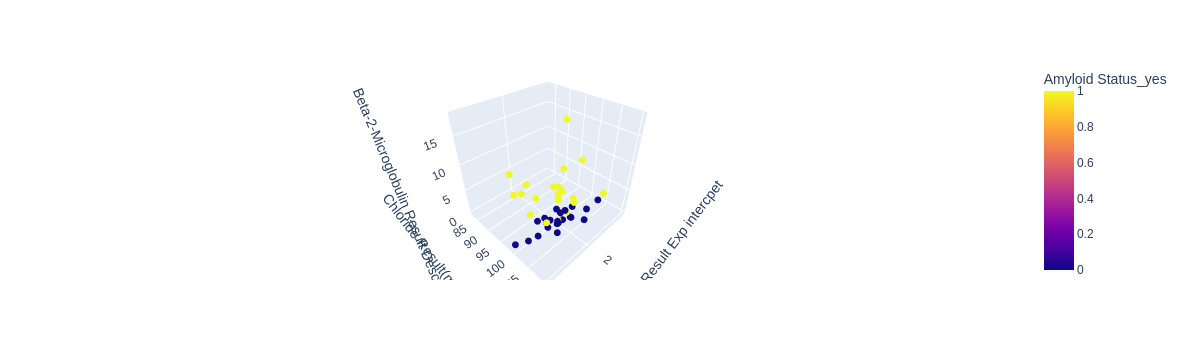

In [31]:
fig = px.scatter_3d(dataTable, x=top_features[0], y=top_features[1], z=top_features[2],
          color=y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

## integrated gradients attribution

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma/mistic/utility.py:223: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



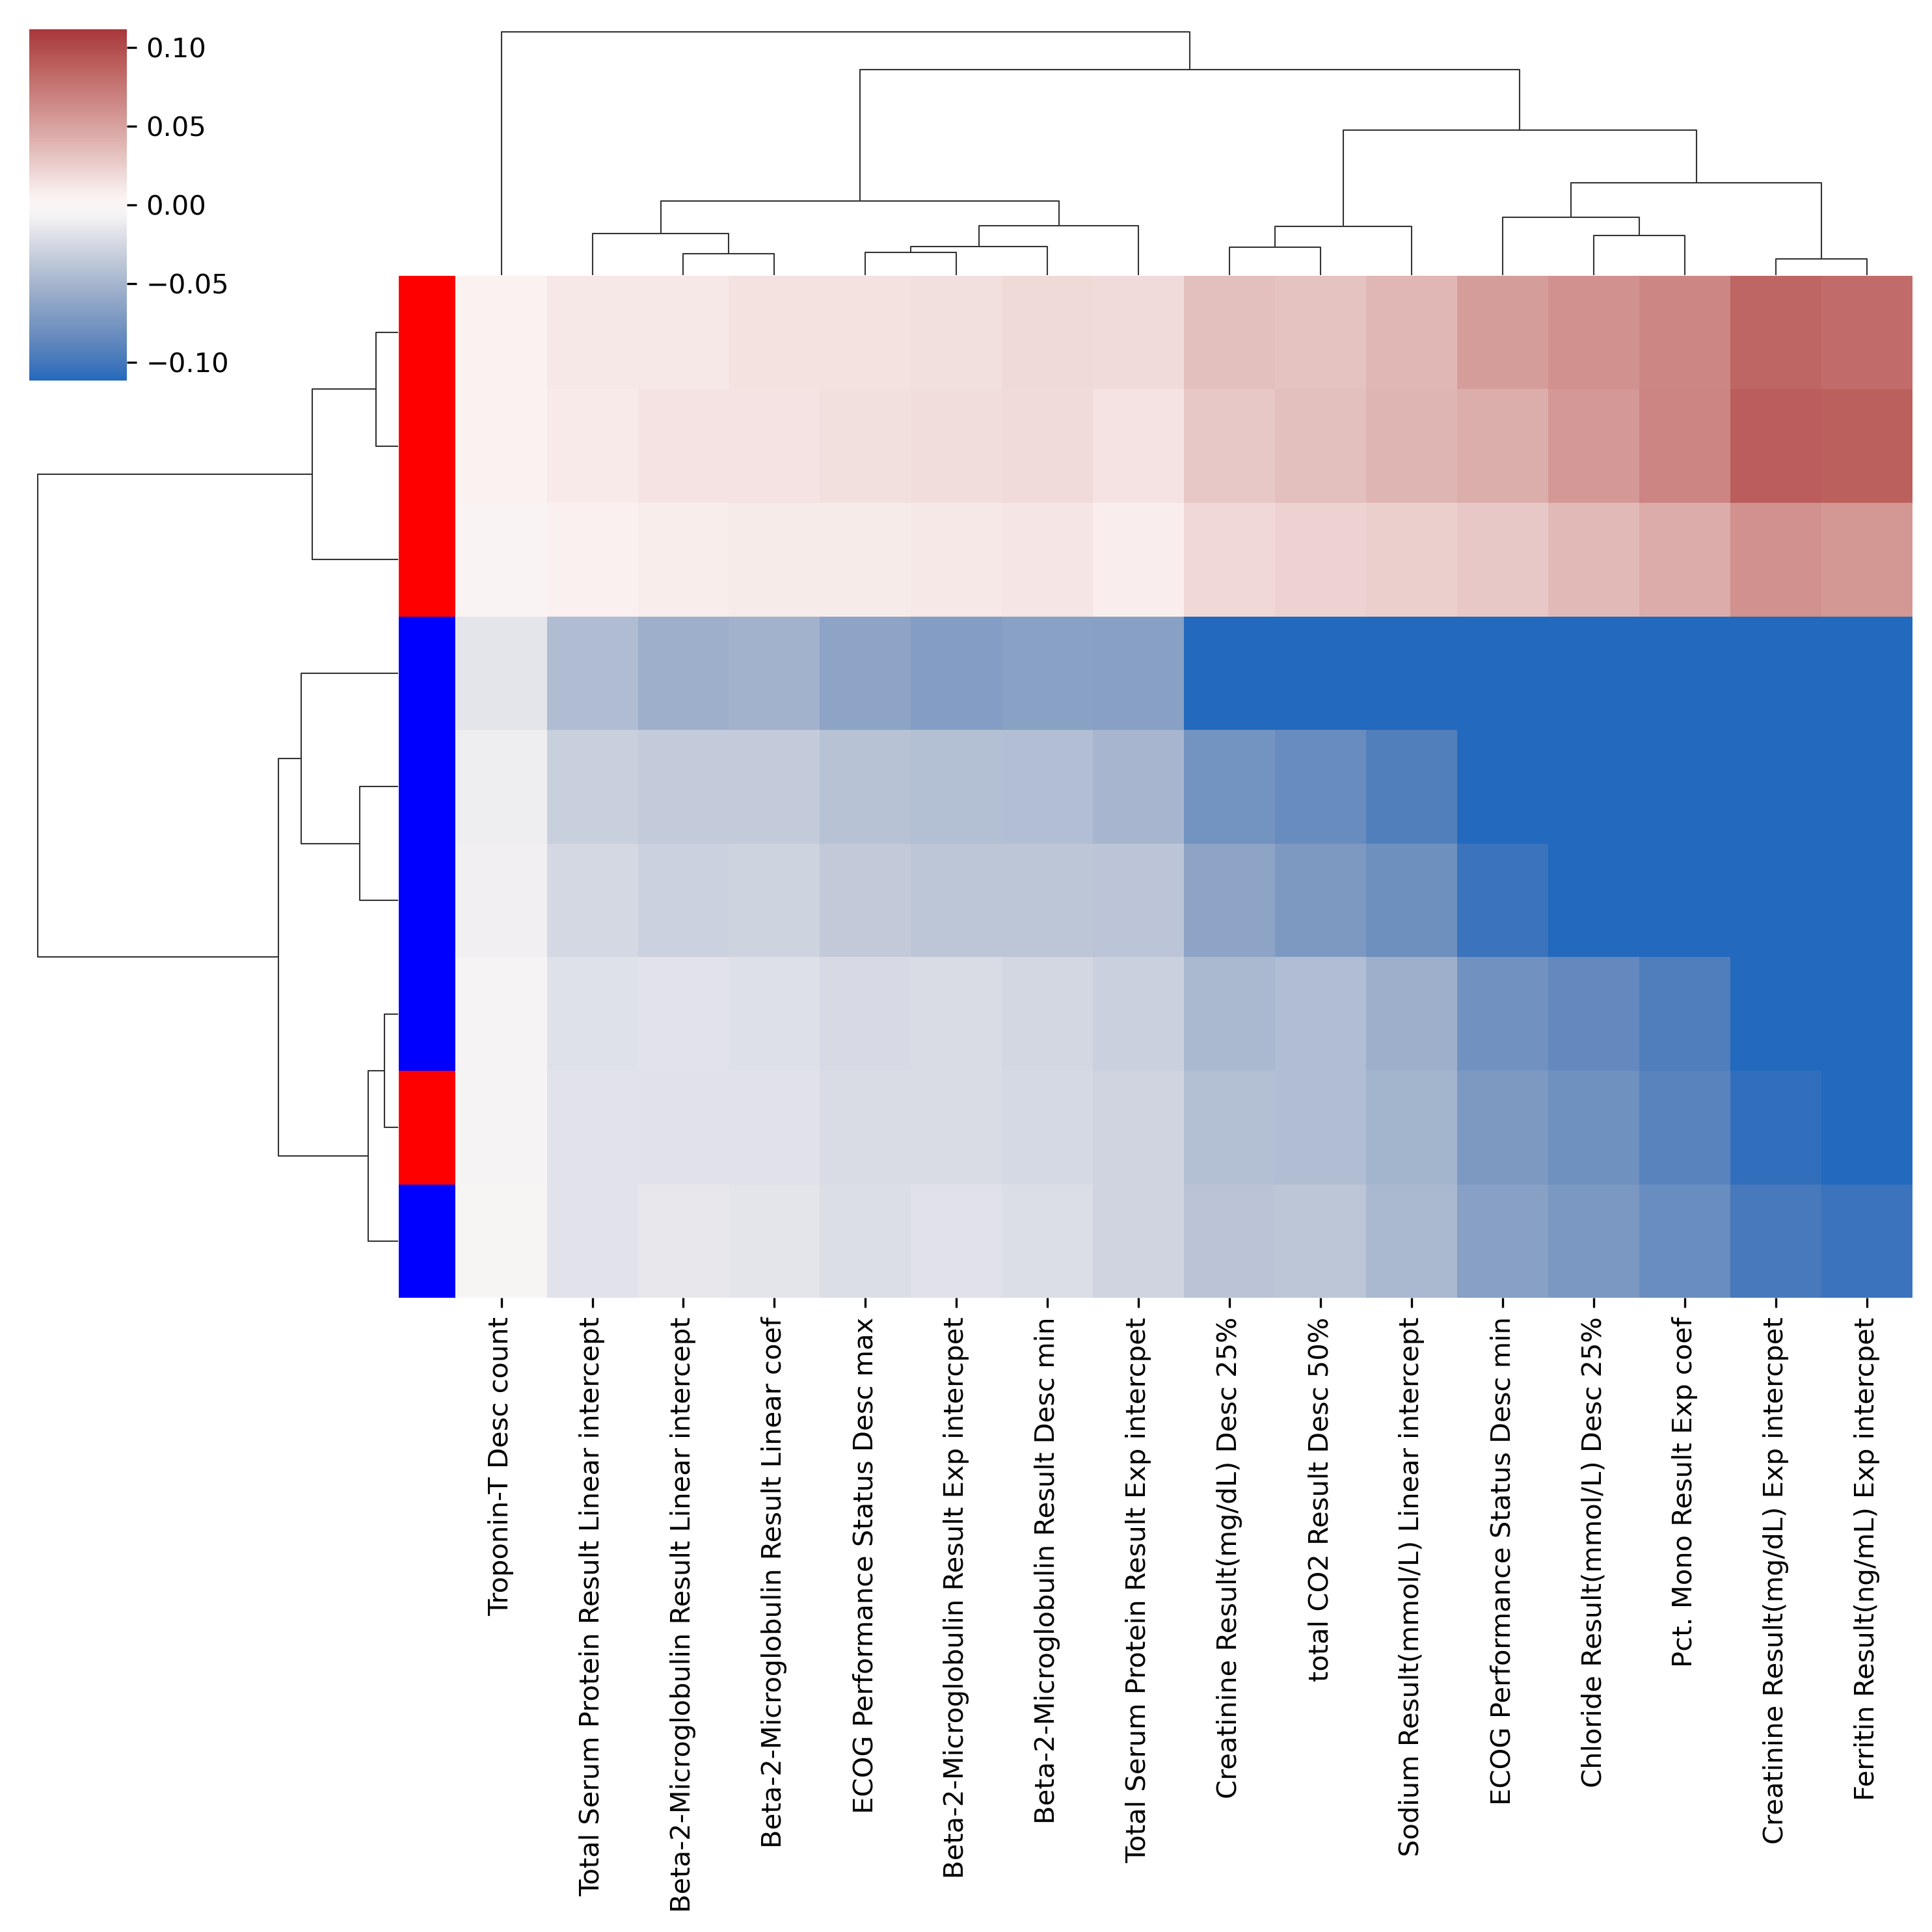

In [32]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

IG = svm_set_ranks[selected_run].integrated_gradient(X_test)

IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

#fig, ax = plt.subplots()
fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_test])

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_IGheatmap"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
fig.savefig(figPath, bbox_inches = 'tight')

In [33]:
# from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

# linkMeth = "average"

# IG = svm_set_ranks[selected_run].integrated_gradient(X_all)

# IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

# distMatCol = perDiff(IGtable)
# hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

# tr_IGtable = IGtable.transpose()
# distMatRow = perDiff(tr_IGtable)
# hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

# color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

# #fig, ax = plt.subplots()
# fig = clustermap(IGtable, 
#            yticklabels=False,
#            cmap="vlag", vmin=-color_val, vmax=color_val,
#            row_linkage=hcRow, col_linkage=hcCol, 
#            row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_test])

# #saving figure
# figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_Xall_IGheatmap"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# # plt.tight_layout()
# fig.savefig(figPath, bbox_inches = 'tight')

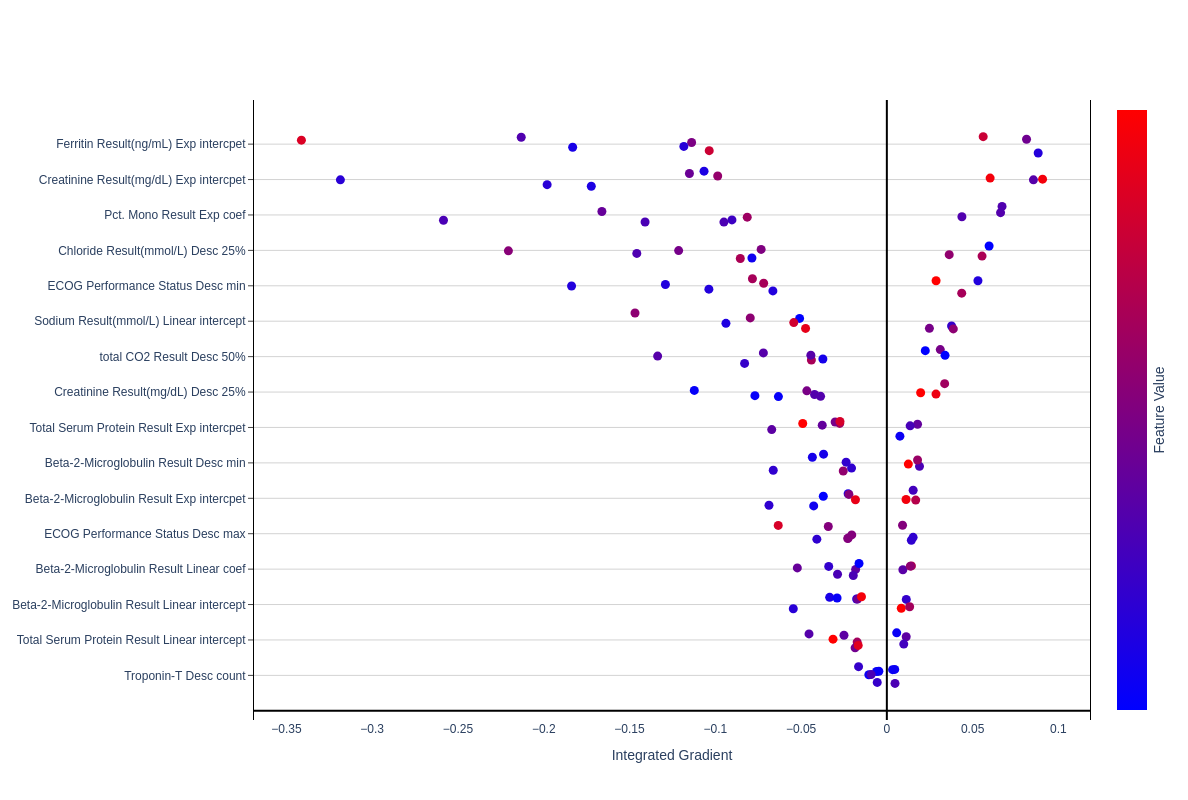

In [34]:
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import numpy as np

features = svm_set_ranks[selected_run].features
df_X_test = pd.DataFrame(X_test[:,features],columns = IGtable.columns)
N = len(IGtable)

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

feature_order = np.argsort(np.sum(abs(IG),axis=0))

y_val = 1
for f in feature_order:
    fig.add_trace(go.Scatter(
        x = IGtable.iloc[:,f], 
        y = y_val + np.random.rand(N)*0.5 - 0.25,
        mode = 'markers',
        marker = dict(size=9,
                      color = df_X_test.iloc[:,f],
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += 1


fig.update_layout(showlegend=False, coloraxis_showscale=True)
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 2)
fig.update_yaxes(tickvals=[i for i in range(1,IGtable.shape[1]+1)], ticktext=IGtable.columns[feature_order])
fig.show() 

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]) + "_attribution"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
#fig.fig.savefig(figPath, bbox_inches = 'tight')
#pio.write_image(fig, figPath)
#fig.show()

In [38]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

IG = svm_set_ranks[selected_run].integrated_gradient(X_all)

IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])


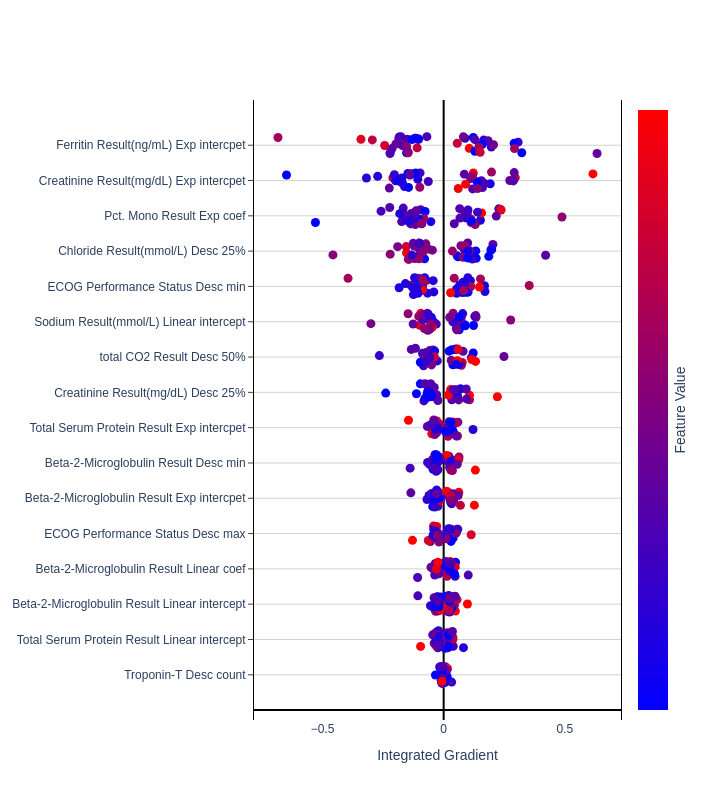

In [39]:
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import numpy as np

features = svm_set_ranks[selected_run].features
df_X_all = pd.DataFrame(X_all[:,features],columns = IGtable.columns)
N = len(IGtable)

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

feature_order = np.argsort(np.sum(abs(IG),axis=0))

y_val = 1
for f in feature_order:
    fig.add_trace(go.Scatter(
        x = IGtable.iloc[:,f], 
        y = y_val + np.random.rand(N)*0.5 - 0.25,
        mode = 'markers',
        marker = dict(size=9,
                      color = df_X_all.iloc[:,f],
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += 1


fig.update_layout(showlegend=False, coloraxis_showscale=True)
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 2)
fig.update_yaxes(tickvals=[i for i in range(1,IGtable.shape[1]+1)], ticktext=IGtable.columns[feature_order])
fig.show() 

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]) + "_Xall_attribution"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
#fig.fig.savefig(figPath, bbox_inches = 'tight')
#pio.write_image(fig, figPath)
#fig.show()

## 2x2

In [36]:
# feat_1 = list(X.columns[svm_set_ranks[selected_run].features])[0]
# feat_2 = list(X.columns[svm_set_ranks[selected_run].features])[1]

# fig = px.scatter(x = df_X_test[feat_1], y = IGtable[feat_1], color = df_X_test[feat_2])
# fig.update_traces(marker=dict(size=12))

# fig.update_layout(
#     plot_bgcolor='white',
#     autosize=False,
#     width=800,
#     height=800,
#     coloraxis = {'colorscale':'Bluered'},
#     xaxis_title = feat_1,
#     yaxis_title = "Integrated Gradient for " + feat_1,
# )

# fig.update_xaxes(
#     zeroline=True,
#     zerolinecolor='lightgrey',
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey'
#     )
    
# fig.update_yaxes(
#     zeroline=True,
#     zerolinecolor='lightgrey',
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey'
# )

# fig.update_coloraxes(colorbar_showticklabels=False,
#                     colorbar_title=dict(text=feat_2,side = "right"),
#                     cmin = -1, cmax = 2)

# fig.show()

# figCommon = fileName_common + str(selected_run) + "_2x2"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# # plt.tight_layout()
# # fig.savefig(figPath, bbox_inches = 'tight')
# fig.show()

In [37]:
feat_1 = list(X.columns[svm_set_ranks[selected_run].features])[0]
feat_2 = list(X.columns[svm_set_ranks[selected_run].features])[1]

fig = px.scatter(x = df_X_all[feat_1], y = IGtable[feat_1], color = df_X_all[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 2)

fig.show()

figCommon = fileName_common + str(selected_run) + "_Xall_2x2"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# plt.tight_layout()
# fig.savefig(figPath, bbox_inches = 'tight')
fig.show()

ValueError: All arguments should have the same length. The length of argument `y` is 9, whereas the length of  previously-processed arguments ['x'] is 44

# sensitivity and specificity 

In [ ]:
decision_values = svm_set_ranks[selected_run].decision_function(X_test)
y_pred = svm_set_ranks[selected_run].predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

print("True Negative: ", tn)
print("false positive: ", fp)
print("false negative: ", fn)
print("true positive: ", tp)
print("true positive rate or recall/sensitivity: ", recall)
print("positive predictive value or precision: ", precision)
print("specificity or true negatie rate: ", specificity)
print("auc: ", auc)
print("f1 score: ", f1)